## NLP classification example

For the example we'll use the [20 Newsgroups](http://qwone.com/~jason/20Newsgroups/) dataset, which is available through [scikit-klearn](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html).

In [48]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='all')

For the results to be better interpretable, we'll just include 3 categories from the dataset, each consisting of 5 documents. To make our lives easier, the categories will be rather distinct.

In [5]:
print(newsgroups_train['DESCR'])

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality 

In [8]:
from functools import reduce

categ = ['alt.atheism', 'comp.graphics', 'rec.sport.baseball']

data = reduce(lambda x, y: x + y, [fetch_20newsgroups(categories=[x], remove=('headers', 'footers'))['data'][:150] for x in categ])

print('Input shape:', len(data), '\n')
print(data[0][:500])

Input shape: 450 

In <16BA7103C3.I3150101@dbstu1.rz.tu-bs.de> I3150101@dbstu1.rz.tu-bs.de (Benedikt Rosenau) writes:

>In article <1993Apr5.091258.11830@monu6.cc.monash.edu.au>
>darice@yoyo.cc.monash.edu.au (Fred Rice) writes:
> 
>(Deletion)
>>>>Of course people say what they think to be the religion, and that this
>>>>is not exactly the same coming from different people within the
>>>>religion.  There is nothing with there existing different perspectives
>>>>within the religion -- perhaps one can say that they t


`data` is a list containing $450$ documents, $150$ from each category (i.e. `'alt.atheism'`, `'comp.graphics'` and `'rec.sport.baseball'`). From these, we'll use $300$ ($100$ from each category) for training the model and $150$ ($50$ from each category) for evaluation.

As in many cases when dealing with text, the data is **pretty raw**. 

We'll first separate the training from the test part.

In [28]:
train = data[:100] + data[150:250] + data[300:400]
test = data[100:150] + data[250:300] + data[400:]
train_labels = np.array([0] * 100 + [1] * 100 + [2] * 100)
test_labels = np.array([0] * 50 + [1] * 50 + [2] * 50)

This time around, instead of preprocessing the documents manually, we'll use scikit-learn's [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html), which can support every [pre-processing](http://scikit-learn.org/stable/modules/feature_extraction.html#customizing-the-vectorizer-classes) we previously saw (stopwords, stemming, lemmatizing, κτλ). We'll also use two extra parameters: `max_df=x`, which ignores any terms that appear in documents with a frequency larger than `x` (i.e. the most common terms) and `max_df=y`, which ignores terms that appear less than `y` times in the corpus (i.e. the least common terms). For this example we won't be performing any stemming/lemmatizing, but the vectorizer does support this functionality (see link above).  

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

tf_idf_train = vectorizer.fit_transform(train).toarray()  # returns a sparse matrix, to convert it to a regular array we use .toarray()
tf_idf_test = vectorizer.transform(test).toarray()  # don't fit on the test set

print('TF-IDF train shape:', tf_idf_train.shape)
print('TF-IDF test shape: ', tf_idf_test.shape)

TF-IDF train shape: (300, 9617)
TF-IDF test shape:  (150, 9617)


$9600$ features is a **very large** number, especially when we have only $450$ samples. Also if a term is encountered in the test set **that was not seen in the training set** then it is not included in the array!

However, we'll proceed to classify the document to get a baseline and then return to reduce some of those features!

In [86]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import time

start_time = time.time()
knn_grid = {'n_neighbors': range(1, 32, 2)}
knn = GridSearchCV(KNeighborsClassifier(), knn_grid, cv=3, iid=False)
knn.fit(tf_idf_train, train_labels)
knn_acc = accuracy_score(test_labels, knn.predict(tf_idf_test)) * 100
print('kNN: {:.2f}%'.format(knn_acc))

dt = DecisionTreeClassifier()
dt.fit(tf_idf_train, train_labels)
dt_acc = accuracy_score(test_labels, dt.predict(tf_idf_test)) * 100
print('DT:  {:.2f}%'.format(dt_acc))

nb = MultinomialNB()
nb.fit(tf_idf_train, train_labels)
nb_acc = accuracy_score(test_labels, nb.predict(tf_idf_test)) * 100
print('NB:  {:.2f}%'.format(nb_acc))

train_time = time.time() - start_time

results = {'exp1': [tf_idf_train.shape[1], train_time, knn_acc, dt_acc, nb_acc]}

print('Total training time for {} features is {} seconds.'.format(tf_idf_train.shape[1], int(train_time)))

kNN: 80.67%
DT:  68.67%
NB:  88.00%
Total training time for 9617 features is 66 seconds.


Now, how can we improve on this baseline.We'll do these steps one by one to see the improvement. The first thing we could try is **stopword removal**.

In [87]:
vectorizer = TfidfVectorizer(stop_words='english')

tf_idf_train = vectorizer.fit_transform(train).toarray()  
tf_idf_test = vectorizer.transform(test).toarray()  

print('TF-IDF train shape:', tf_idf_train.shape)
print('TF-IDF test shape: ', tf_idf_test.shape)

start_time = time.time()
knn_grid = {'n_neighbors': range(1, 32, 2)}
knn = GridSearchCV(KNeighborsClassifier(), knn_grid, cv=3, iid=False)
knn.fit(tf_idf_train, train_labels)
knn_acc = accuracy_score(test_labels, knn.predict(tf_idf_test)) * 100
print('kNN: {:.2f}%'.format(knn_acc))

dt = DecisionTreeClassifier()
dt.fit(tf_idf_train, train_labels)
dt_acc = accuracy_score(test_labels, dt.predict(tf_idf_test)) * 100
print('DT:  {:.2f}%'.format(dt_acc))

nb = MultinomialNB()
nb.fit(tf_idf_train, train_labels)
nb_acc = accuracy_score(test_labels, nb.predict(tf_idf_test)) * 100
print('NB:  {:.2f}%'.format(nb_acc))

train_time = time.time() - start_time

results['exp2'] = [tf_idf_train.shape[1], train_time, knn_acc, dt_acc, nb_acc]

print('Total training time for {} features is {} seconds.'.format(tf_idf_train.shape[1], int(train_time)))

TF-IDF train shape: (300, 9338)
TF-IDF test shape:  (150, 9338)
kNN: 97.33%
DT:  76.00%
NB:  98.67%
Total training time for 9338 features is 60 seconds.


Stopword removal amounted to the removal of around $300$ features (which are usually not useful for classication). Even though we didn't achieve a large reduction in training time, we managed to **increase the performance** of the classifiers noticably!

Next up, we'll try set a `max_df` argument. This drops all terms that have a frequency larger than the given number. The intuition behind this is that terms that appear in many documents (over many different topics) aren't very useful for distinguishing between them.

In [88]:
vectorizer = TfidfVectorizer(max_df=0.4)  # drop all terms that appear in at least 40% of the documents

tf_idf_train = vectorizer.fit_transform(train).toarray()  
tf_idf_test = vectorizer.transform(test).toarray()  

print('TF-IDF train shape:', tf_idf_train.shape)
print('TF-IDF test shape: ', tf_idf_test.shape)

start_time = time.time()
knn_grid = {'n_neighbors': range(1, 32, 2)}
knn = GridSearchCV(KNeighborsClassifier(), knn_grid, cv=3, iid=False)
knn.fit(tf_idf_train, train_labels)
knn_acc = accuracy_score(test_labels, knn.predict(tf_idf_test)) * 100
print('kNN: {:.2f}%'.format(knn_acc))

dt = DecisionTreeClassifier()
dt.fit(tf_idf_train, train_labels)
dt_acc = accuracy_score(test_labels, dt.predict(tf_idf_test)) * 100
print('DT:  {:.2f}%'.format(dt_acc))

nb = MultinomialNB()
nb.fit(tf_idf_train, train_labels)
nb_acc = accuracy_score(test_labels, nb.predict(tf_idf_test)) * 100
print('NB:  {:.2f}%'.format(nb_acc))

train_time = time.time() - start_time

results['exp3'] = [tf_idf_train.shape[1], train_time, knn_acc, dt_acc, nb_acc]

print('Total training time for {} features is {} seconds.'.format(tf_idf_train.shape[1], int(train_time)))

TF-IDF train shape: (300, 9592)
TF-IDF test shape:  (150, 9592)
kNN: 92.67%
DT:  74.00%
NB:  96.67%
Total training time for 9592 features is 73 seconds.


This didn't have almost any effect in reducing the features, however it increased performance!

The next thing we'll try is to set a `min_df`. This drops the terms that appear the **least** amount of times. The intuition is that these features are so rare that they aren't useful. 

In [89]:
vectorizer = TfidfVectorizer(min_df=5)  # drop all terms that appear less than 5 documents

tf_idf_train = vectorizer.fit_transform(train).toarray()  
tf_idf_test = vectorizer.transform(test).toarray()  

print('TF-IDF train shape:', tf_idf_train.shape)
print('TF-IDF test shape: ', tf_idf_test.shape)

start_time = time.time()
knn_grid = {'n_neighbors': range(1, 32, 2)}
knn = GridSearchCV(KNeighborsClassifier(), knn_grid, cv=3, iid=False)
knn.fit(tf_idf_train, train_labels)
knn_acc = accuracy_score(test_labels, knn.predict(tf_idf_test)) * 100
print('kNN: {:.2f}%'.format(knn_acc))

dt = DecisionTreeClassifier()
dt.fit(tf_idf_train, train_labels)
dt_acc = accuracy_score(test_labels, dt.predict(tf_idf_test)) * 100
print('DT:  {:.2f}%'.format(dt_acc))

nb = MultinomialNB()
nb.fit(tf_idf_train, train_labels)
nb_acc = accuracy_score(test_labels, nb.predict(tf_idf_test)) * 100
print('NB:  {:.2f}%'.format(nb_acc))

train_time = time.time() - start_time

results['exp4'] = [tf_idf_train.shape[1], train_time, knn_acc, dt_acc, nb_acc]

print('Total training time for {} features is {} seconds.'.format(tf_idf_train.shape[1], int(train_time)))

TF-IDF train shape: (300, 1362)
TF-IDF test shape:  (150, 1362)
kNN: 84.00%
DT:  69.33%
NB:  95.33%
Total training time for 1362 features is 9 seconds.


Wow, this **massively reduced training time** while also **improving the perfomance** of the models! 

The last thing we'll try is to add a stemmer. This is a bit trickier.

In [90]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
analyzer = TfidfVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

vectorizer = TfidfVectorizer(analyzer=stemmed_words)  

tf_idf_train = vectorizer.fit_transform(train).toarray()  
tf_idf_test = vectorizer.transform(test).toarray()  

print('TF-IDF train shape:', tf_idf_train.shape)
print('TF-IDF test shape: ', tf_idf_test.shape)

start_time = time.time()
knn_grid = {'n_neighbors': range(1, 32, 2)}
knn = GridSearchCV(KNeighborsClassifier(), knn_grid, cv=3, iid=False)
knn.fit(tf_idf_train, train_labels)
knn_acc = accuracy_score(test_labels, knn.predict(tf_idf_test)) * 100
print('kNN: {:.2f}%'.format(knn_acc))

dt = DecisionTreeClassifier()
dt.fit(tf_idf_train, train_labels)
dt_acc = accuracy_score(test_labels, dt.predict(tf_idf_test)) * 100
print('DT:  {:.2f}%'.format(dt_acc))

nb = MultinomialNB()
nb.fit(tf_idf_train, train_labels)
nb_acc = accuracy_score(test_labels, nb.predict(tf_idf_test)) * 100
print('NB:  {:.2f}%'.format(nb_acc))

train_time = time.time() - start_time

results['exp5'] = [tf_idf_train.shape[1], train_time, knn_acc, dt_acc, nb_acc]

print('Total training time for {} features is {} seconds.'.format(tf_idf_train.shape[1], int(train_time)))

TF-IDF train shape: (300, 7428)
TF-IDF test shape:  (150, 7428)
kNN: 84.00%
DT:  75.33%
NB:  88.67%
Total training time for 7428 features is 52 seconds.


Let's compare the techniques

Text(0.5, 1.0, 'Number of features')

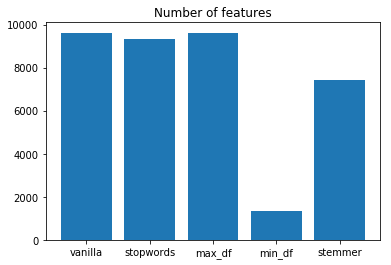

In [97]:
experiments = ['exp' + str(i) for i in range(1, 6)]
labels = ['vanilla', 'stopwords', 'max_df', 'min_df', 'stemmer']
plt.bar(labels, [results[x][0] for x in experiments])
plt.title('Number of features')

Only `min_df` actually managed to significantly reduce dimensions.

Text(0.5, 1.0, 'Training time')

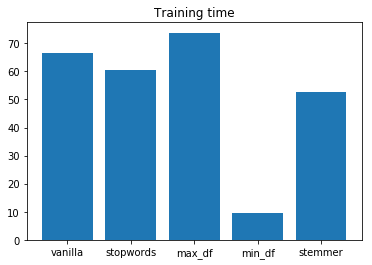

In [98]:
plt.bar(labels, [results[x][1] for x in experiments])
plt.title('Training time')

This follows the trend of the previous plot.

Text(0.5, 1.0, 'kNN accuracy')

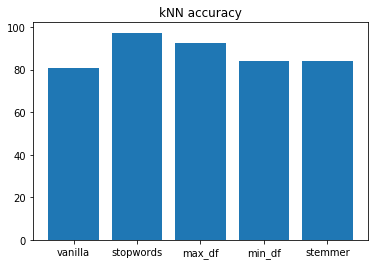

In [100]:
plt.bar(labels, [results[x][2] for x in experiments])
plt.title('kNN accuracy')

Dropping common words improved performance the most, as indicated by `stopwords` and `max_df`. An interesting note is that while `min_df` and the `stemmer` managed to reduce dimensions, they **didn't** suffer from reduced performance.  

Text(0.5, 1.0, 'Decision Tree accuracy')

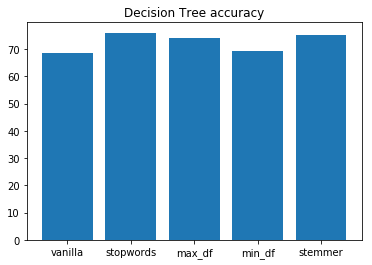

In [101]:
plt.bar(labels, [results[x][3] for x in experiments])
plt.title('Decision Tree accuracy')

Text(0.5, 1.0, 'Naive Bayes accuracy')

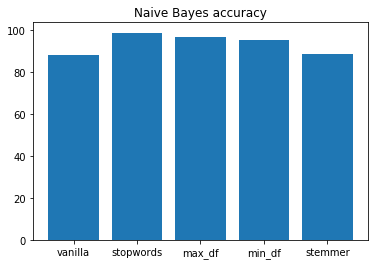

In [102]:
plt.bar(labels, [results[x][4] for x in experiments])
plt.title('Naive Bayes accuracy')

Let's put the first 3 parameters together.

In [104]:
vectorizer = TfidfVectorizer(min_df=5, max_df=0.4, stop_words='english')

tf_idf_train = vectorizer.fit_transform(train).toarray()  
tf_idf_test = vectorizer.transform(test).toarray()  

print('TF-IDF train shape:', tf_idf_train.shape)
print('TF-IDF test shape: ', tf_idf_test.shape)

start_time = time.time()
knn_grid = {'n_neighbors': range(1, 32, 2)}
knn = GridSearchCV(KNeighborsClassifier(), knn_grid, cv=3, iid=False)
knn.fit(tf_idf_train, train_labels)
knn_acc = accuracy_score(test_labels, knn.predict(tf_idf_test)) * 100
print('kNN: {:.2f}%'.format(knn_acc))

dt = DecisionTreeClassifier()
dt.fit(tf_idf_train, train_labels)
dt_acc = accuracy_score(test_labels, dt.predict(tf_idf_test)) * 100
print('DT:  {:.2f}%'.format(dt_acc))

nb = MultinomialNB()
nb.fit(tf_idf_train, train_labels)
nb_acc = accuracy_score(test_labels, nb.predict(tf_idf_test)) * 100
print('NB:  {:.2f}%'.format(nb_acc))

train_time = time.time() - start_time

results['exp6'] = [tf_idf_train.shape[1], train_time, knn_acc, dt_acc, nb_acc]

print('Total training time for {} features is {} seconds.'.format(tf_idf_train.shape[1], int(train_time)))

TF-IDF train shape: (300, 1134)
TF-IDF test shape:  (150, 1134)
kNN: 96.67%
DT:  79.33%
NB:  99.33%
Total training time for 1134 features is 7 seconds.


Text(0.5, 1.0, 'Naive Bayes accuracy')

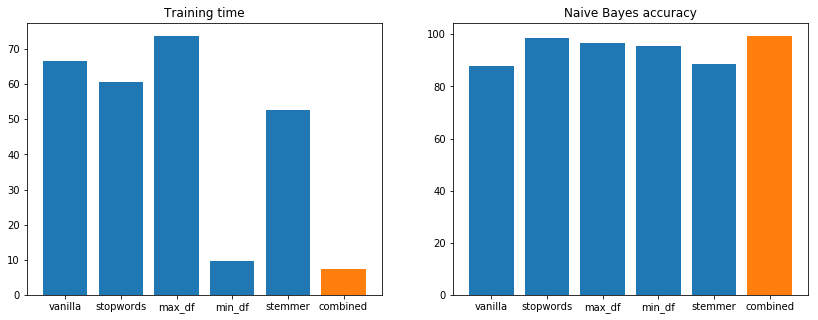

In [109]:
plt.figure(figsize=(14, 5))

experiments += ['exp6']
labels += ['combined']
colors = ['C0'] * 5 + ['C1']

ax = plt.subplot(121)
ax.bar(labels, [results[x][1] for x in experiments], color=colors)
ax.set_title('Training time')

ax = plt.subplot(122)
ax.bar(labels, [results[x][4] for x in experiments], color=colors)
ax.set_title('Naive Bayes accuracy')

The new model **scored the best results**, while **taking the least amount of time to train**! 

Keep in mind that preprocessing is king in NLP!